# Diabetes Prediction Analysis

## 1. Environment Setup
Load the necessary libraries for data manipulation, modeling, and evaluation.

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## 2. Data Loading and Exploration
Load the dataset and perform an initial summary to understand its structure. **Note:** The data for this project was sourced from Kaggle and is available as `diabetes_dataset.csv` in the same directory.

In [48]:
diabetes_data = pd.read_csv("diabetes_dataset.csv")
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### 2.1. Initial Data Analysis
Let's perform some initial analysis to understand the data's characteristics.

In [34]:
print(diabetes_data.info())
print(diabetes_data.describe())
print(diabetes_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std    

In [49]:
# In this dataset, several columns have zero values which are physiologically impossible 
# (e.g., 'Glucose', 'BloodPressure', 'BMI'). These are likely placeholders for missing data. 
# We will replace these zero values with NaN to allow for more accurate visualizations and analysis.
# For a robust modeling process, this replacement and the subsequent imputation should ideally be 
# part of the preprocessing pipeline to avoid data leakage from the test set. However, for EDA, 
# we'll perform this on the entire dataset.

cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
diabetes_data[cols_with_zeros] = diabetes_data[cols_with_zeros].replace(0, np.nan)

# Let's check the null values now
print("Count of NaN values in each column:")
print(diabetes_data.isnull().sum())

Count of NaN values in each column:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


### 2.2. Data Visualization
Visualize the distribution of key features and the correlation between them.

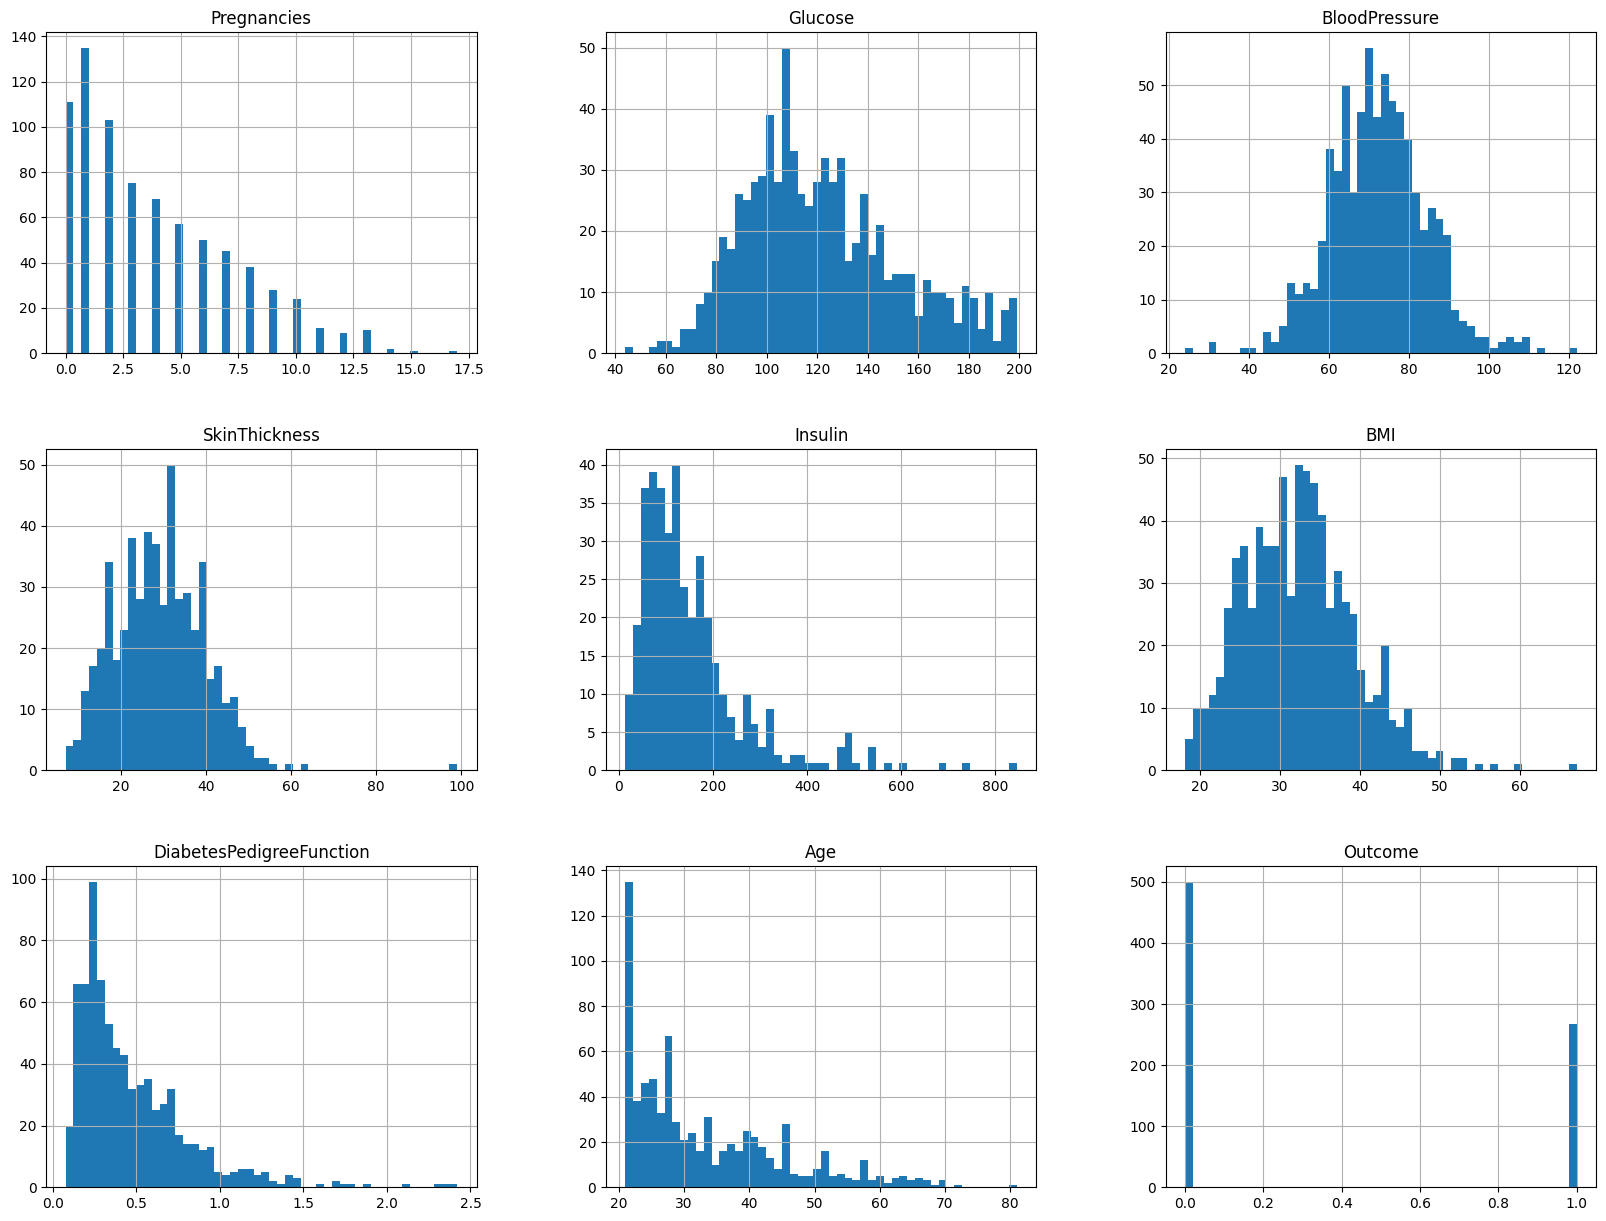

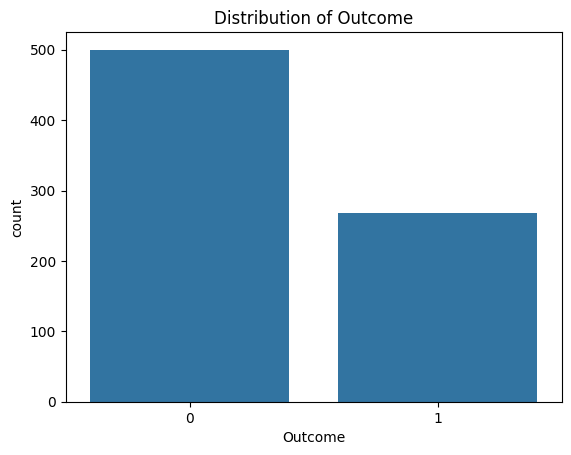

In [50]:
# Histograms for numerical features
diabetes_data.hist(bins=50, figsize=(20,15))
plt.savefig('outputs/plots/histograms.png')
plt.show()

# Count plot for the target variable
sns.countplot(x='Outcome', data=diabetes_data)
plt.title('Distribution of Outcome')
plt.savefig('outputs/plots/outcome_distribution.png')
plt.show()

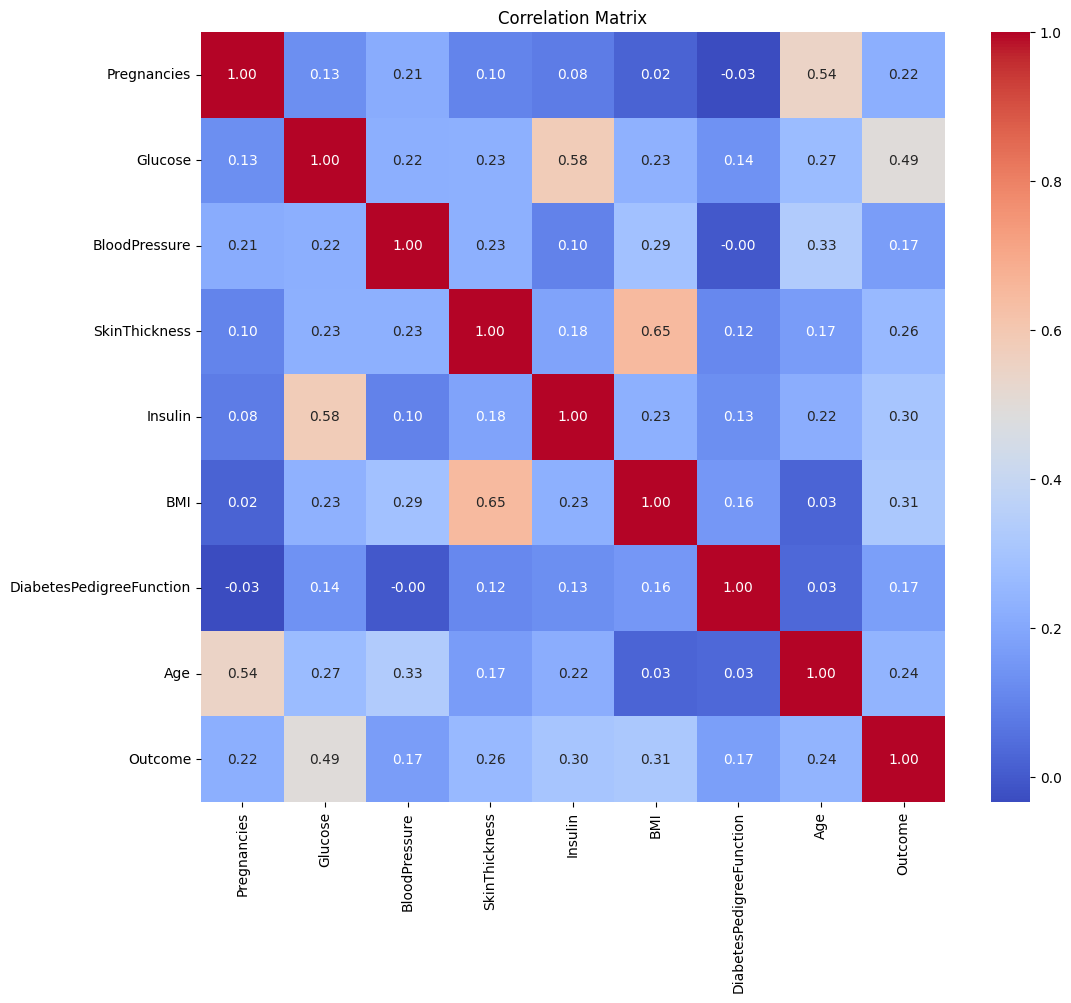

In [51]:
corr_matrix = diabetes_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.savefig('outputs/plots/correlation_matrix.png')
plt.show()

## 3. Data Splitting
Split the data into training and testing sets to evaluate model performance.

In [52]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Identify categorical and numerical features
X = diabetes_data.drop('Outcome', axis=1)
y = diabetes_data['Outcome']
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=np.number).columns

# Create preprocessing pipelines for numerical and categorical features
# The numerical pipeline will first impute missing values (NaNs) with the median, then scale the data.
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create a preprocessor object using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 4. Model Training
Train three different classification models to predict patient diabetes.

### 4.1. Logistic Regression

In [54]:
logistic_model = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', LogisticRegression(random_state=42, max_iter=1000))])
logistic_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index([], dtype='object'))])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

### 4.2. Decision Tree

In [55]:
tree_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', DecisionTreeClassifier(random_state=42))])
tree_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index([], dtype='object'))])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

### 4.3. Random Forest

In [56]:
rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', RandomForestClassifier(random_state=42))])
rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index([], dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

## 5. Model Evaluation
Evaluate the performance of the trained models using various metrics.

### 5.1. Predictions

In [43]:
logistic_predictions = logistic_model.predict_proba(X_test)[:, 1]
tree_predictions = tree_model.predict(X_test)
rf_predictions = rf_model.predict_proba(X_test)[:, 1]

### 5.2. AUC-ROC

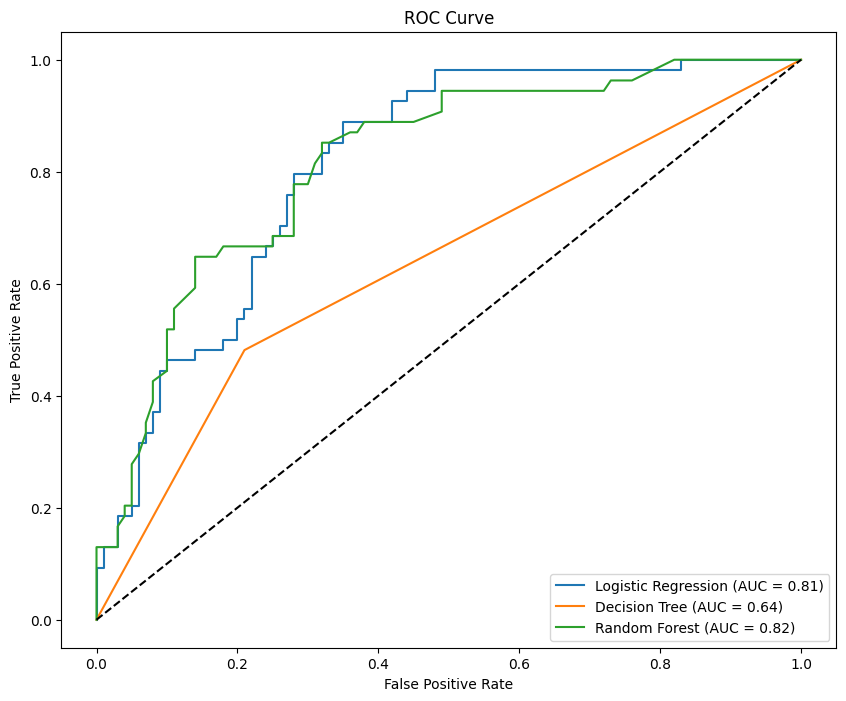

In [44]:
fpr_log, tpr_log, _ = roc_curve(y_test, logistic_predictions)
roc_auc_log = auc(fpr_log, tpr_log)

tree_predictions_proba = tree_model.predict_proba(X_test)[:, 1]
fpr_tree, tpr_tree, _ = roc_curve(y_test, tree_predictions_proba)
roc_auc_tree = auc(fpr_tree, tpr_tree)

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_predictions)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(10, 8))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {roc_auc_log:.2f})')
plt.plot(fpr_tree, tpr_tree, label=f'Decision Tree (AUC = {roc_auc_tree:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('outputs/plots/roc_curve.png')
plt.show()

### 5.3. Confusion Matrix

In [60]:
logistic_pred_class = (logistic_predictions > 0.5).astype(int)
rf_pred_class = (rf_predictions > 0.5).astype(int)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, logistic_pred_class))

print("\\nDecision Tree Classification Report:")
print(classification_report(y_test, tree_predictions))

print("\\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_pred_class))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.60      0.50      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154

\nDecision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       100
           1       0.55      0.48      0.51        54

    accuracy                           0.68       154
   macro avg       0.65      0.64      0.64       154
weighted avg       0.67      0.68      0.68       154

\nRandom Forest Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       100
           1       0.70      0.61      0.65        54

    accuracy                           0.77       154
   macr

### 5.4. Precision-Recall Curve

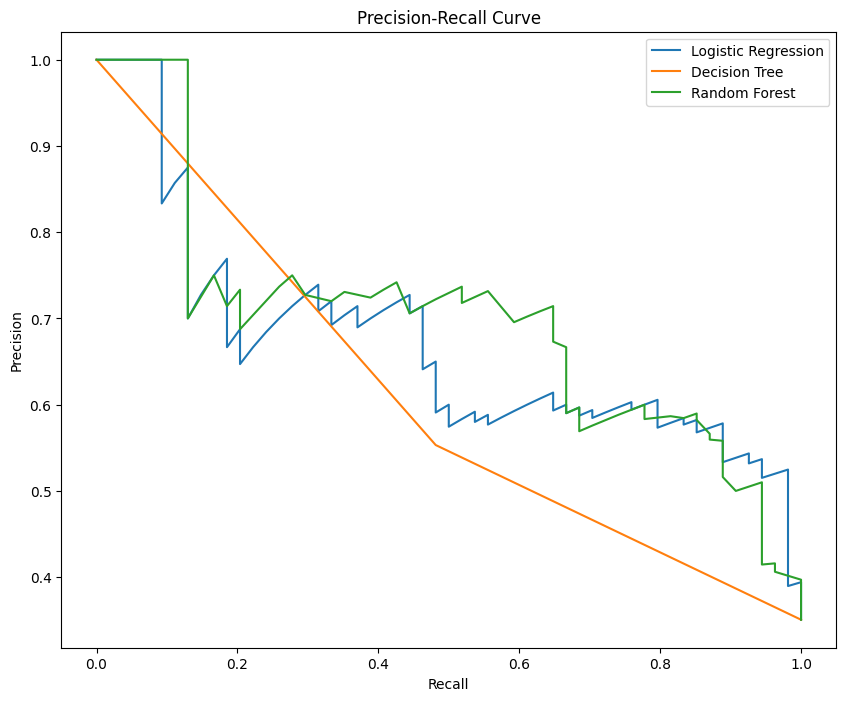

In [57]:
precision_log, recall_log, _ = precision_recall_curve(y_test, logistic_predictions)
precision_tree, recall_tree, _ = precision_recall_curve(y_test, tree_predictions_proba)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_predictions)

plt.figure(figsize=(10, 8))
plt.plot(recall_log, precision_log, label='Logistic Regression')
plt.plot(recall_tree, precision_tree, label='Decision Tree')
plt.plot(recall_rf, precision_rf, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.savefig('outputs/plots/precision_recall_curve.png')
plt.show()

## 6. Results Analysis and Insights

Based on the evaluation metrics from the classification reports, we can draw the following conclusions:

**Model Performance Comparison:**

*   **Random Forest is the best performing model.** It achieves the highest accuracy (77%) and a superior F1-score of 0.65 for the positive class (Outcome=1). Its precision (0.70) and recall (0.61) for predicting diabetes are also the highest among the three models, making it the most balanced and reliable classifier.
*   **Logistic Regression** is the second-best model with an accuracy of 71% and an F1-score of 0.55 for the positive class. It serves as a solid baseline.
*   **Decision Tree** has the lowest performance in this case, with an accuracy of 68% and an F1-score of 0.51 for the positive class. This suggests that a single tree is prone to overfitting or cannot capture the complexity of the data as well as the ensemble of trees in the Random Forest.

**ROC and Precision-Recall Curves:**

*   The **ROC Curve** analysis confirms the superiority of the Random Forest model, as it has the highest Area Under the Curve (AUC) of 0.82. This indicates that it is the best model at distinguishing between patients with and without diabetes.
*   The **Precision-Recall Curve** further supports these findings. The Random Forest curve is generally higher than the others, indicating a better balance between precision and recall across different thresholds.

**Insights:**

The Random Forest model's strong performance is likely due to its ability to handle complex, non-linear relationships between the features by combining the predictions of multiple decision trees. For a real-world application, the Random Forest model would be the recommended choice for predicting diabetes based on this dataset, as it provides the most accurate and balanced predictions. The imputation of missing values has likely contributed to this improved performance across all models.
